In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import simulation_utils as su
import importlib

In [8]:
len(PSD_freq)

5001

Let's try just doing standard optimal filter assuming stationary and see how well it does

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4


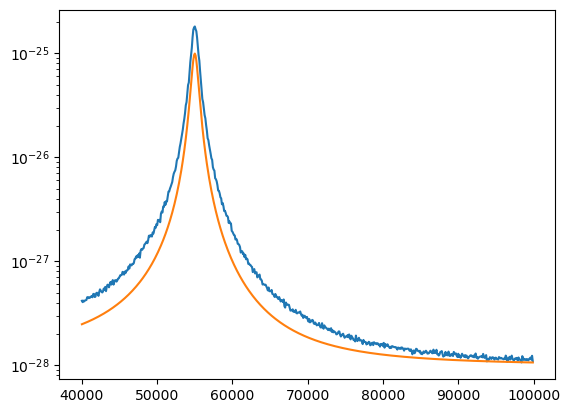

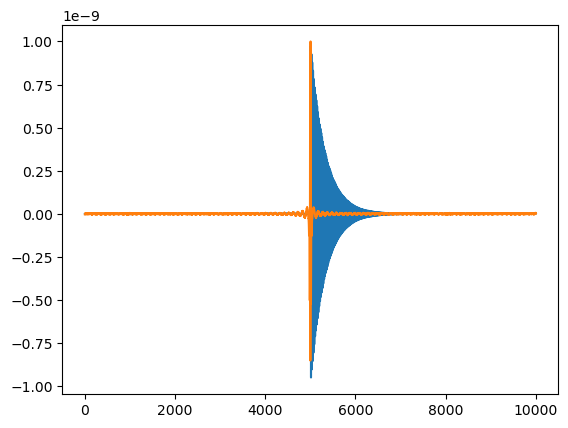

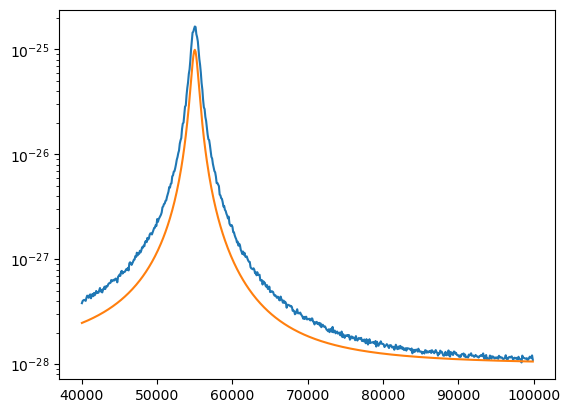

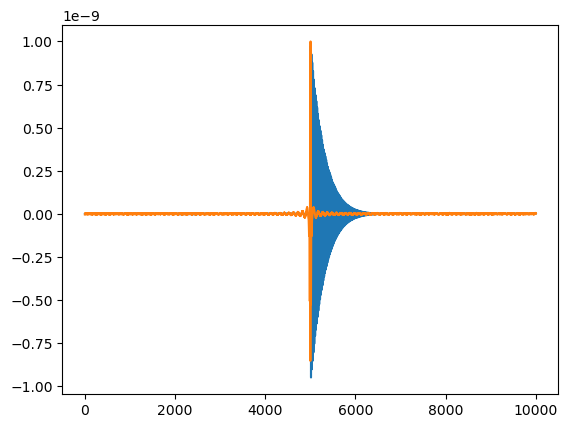

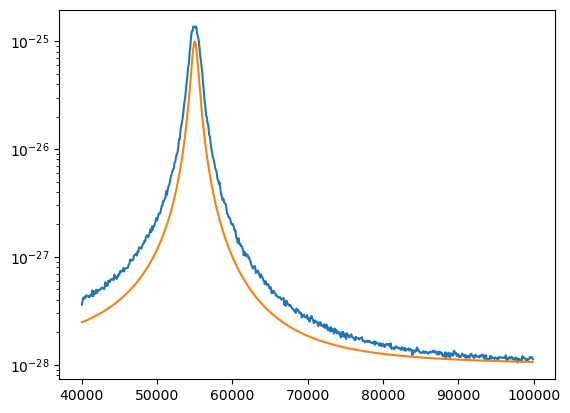

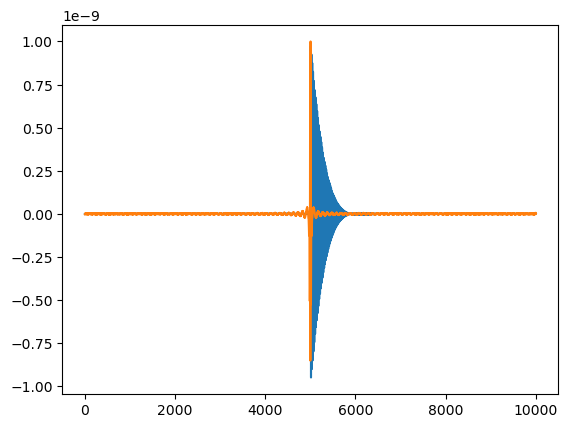

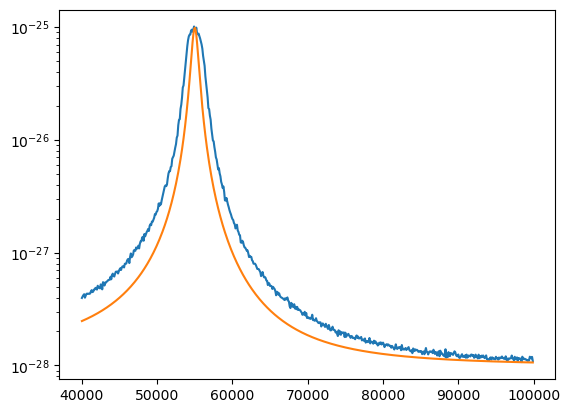

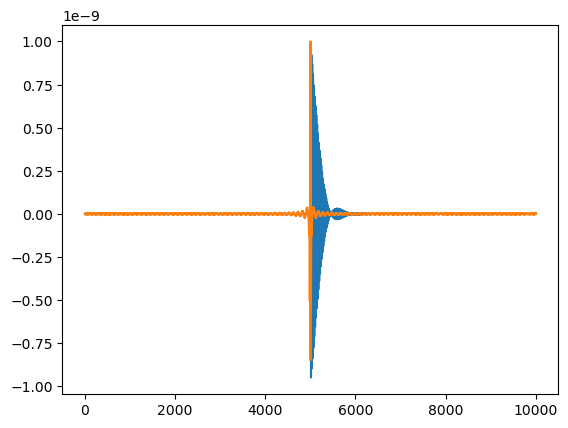

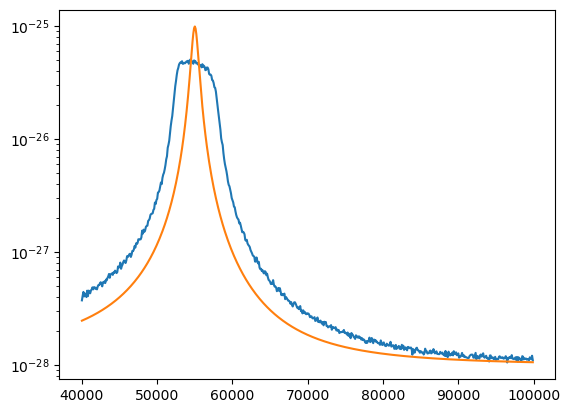

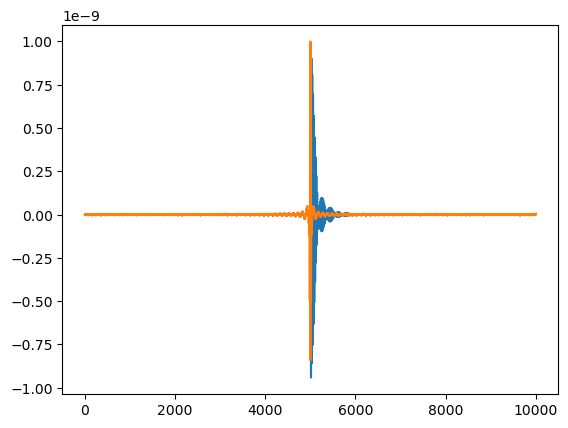

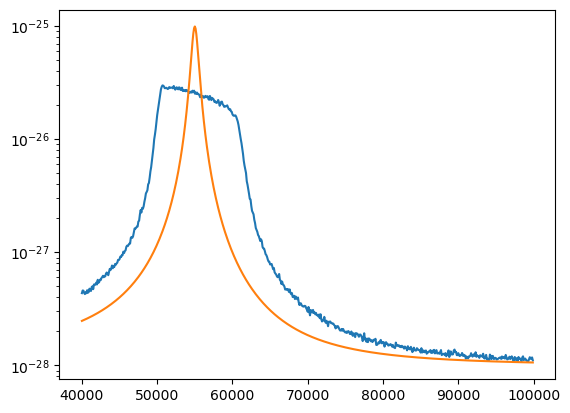

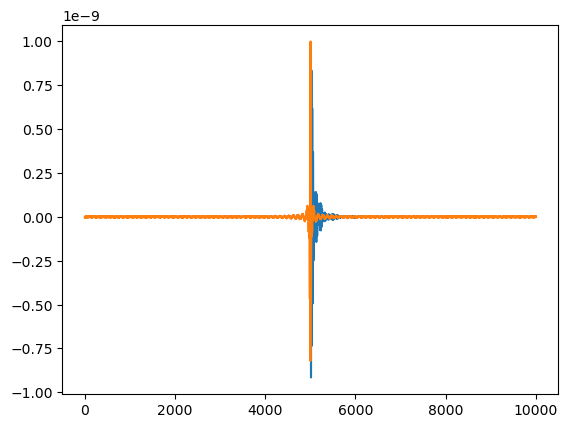

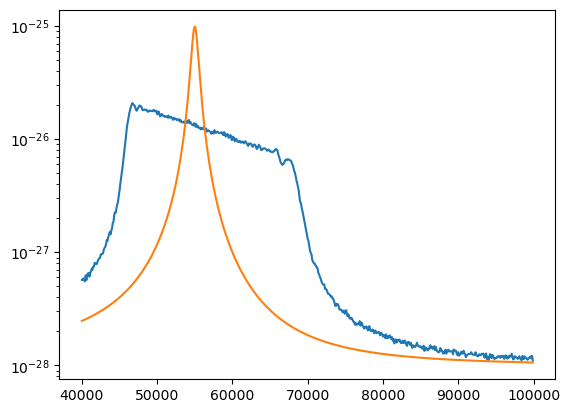

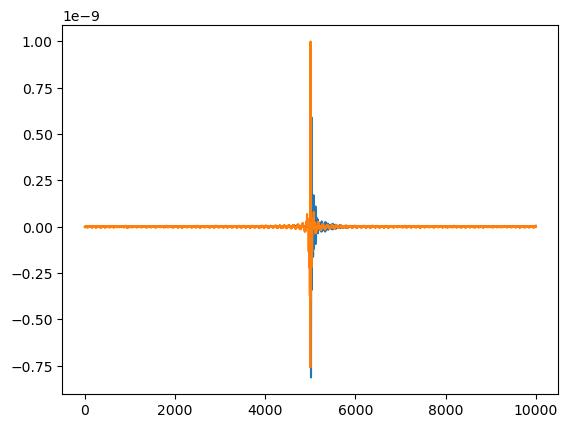

In [378]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for yfb in yfb_l:
    for iter in iter_l:

        numbins = int(2*5*10**4*100*2*np.pi/yfb)

        filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

        data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
        PSD_freq = data['frequency']
        PSD_noise = data['J']

        data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
        avr_resp = data['x']

        lb = 400
        ub = 1000
        plt.figure()
        plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
        plt.plot(PSD_freq[lb:ub], au.Linewidth2(np.array(PSD_freq[lb:ub]), 0.3*10**(-12), 55000, 1000, 10**(-28)))
        plt.yscale('log')

        plt.figure()
        plt.plot(avr_resp)

        phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

        plt.plot(phi_t*10**(-9))

        corr_max = []
        #corr_arg = []
        #corr_data_l = np.zeros((1000, numbins))
        for i in range(1000):
            data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
            x = data['x']
            cm = au.optimal_filter(phi_t, x)
            corr_max.append(cm)
        print(1)
        
        corr_max_n = []
        #corr_data_l_n = np.zeros((1000, numbins))
        np.random.seed(3716)
        for i in range(1000):
            data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            x = data['x']
            cm = au.optimal_filter_noise(phi_t, x)
            corr_max_n.append(cm)
        print(2)
        cf = 55000
        BW = 30000
        amp_max = []
        for i in range(1000):
            max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max.append(max)
        
        print(3)
        
        amp_max_n = []
        for i in range(1000):
            max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            amp_max_n.append(max)

        print(4)
        
        analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
        au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

Text(0, 0.5, 'Width of reconstruction (arb)')

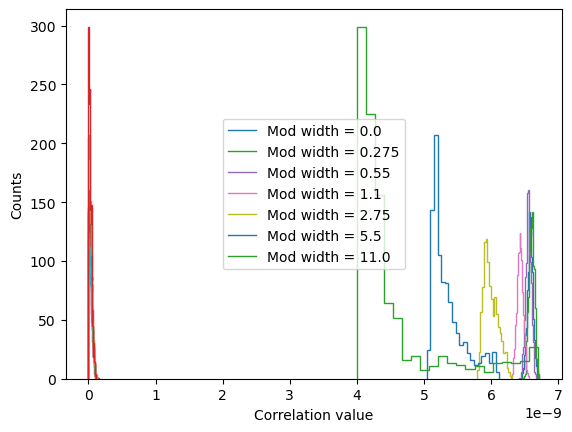

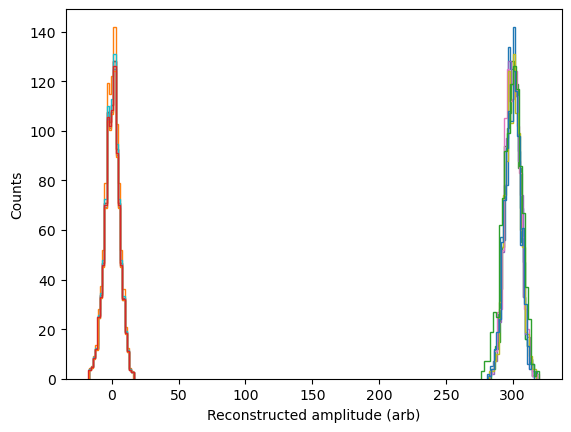

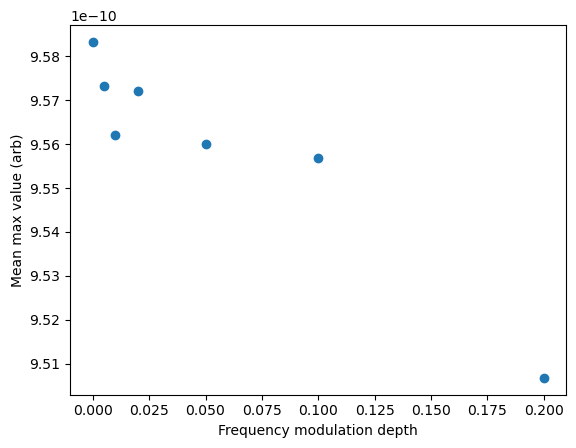

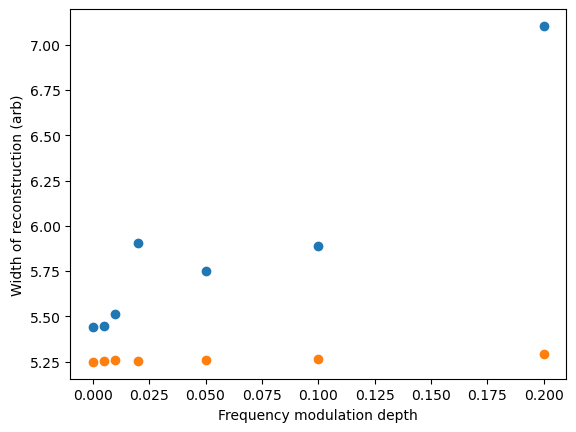

In [379]:
filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for yfb in yfb_l:
    for iter in iter_l:
        mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')

        corr_max = mdict['Kicks']
        corr_max_n = mdict['Kicks noise']
    
        hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
        hist2, bins2, fit2, x_hist2, fitted2 = au.histogram_and_fit(corr_max_n, 20, 5, fit = True, plot = False)

        plt.stairs(hist1, bins1, label = 'Mod width = ' + str(iter*55000/1000))
        plt.stairs(hist2/np.max(hist2)*np.max(hist1), bins2)
 
plt.xlabel('Correlation value')
plt.ylabel('Counts') 
plt.legend()

plt.figure()

mean3_l = []
width3_l = []
width4_l = []

for yfb in yfb_l:
    for iter in iter_l:
        mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')

        amp_max = mdict['Band-pass filter']
        amp_max_n_max = mdict['Band-pass filter noise']
    
        hist3, bins3, fit3, x_hist3, fitted3 = au.histogram_and_fit(amp_max, 20, 5, fit = True, plot = False)
        hist4, bins4, fit4, x_hist4, fitted4 = au.histogram_and_fit(amp_max_n, 20, 5, fit = True, plot = False)
        width3_l.append(abs(fit3[2]))
        mean3_l.append(abs(fit3[1]))
        width4_l.append(abs(fit4[2]))

        plt.stairs(hist3, bins3*300/abs(fit3[1]))
        plt.stairs(hist4/np.max(hist4)*np.max(hist3), bins4*300/abs(fit3[1]))
        plt.xlabel('Reconstructed amplitude (arb)')
        plt.ylabel('Counts')

mean3_l = np.array(mean3_l)
width3_l = np.array(width3_l)
width4_l = np.array(width4_l)

plt.xlabel('Reconstructed amplitude (arb)')
plt.ylabel('Counts')

plt.figure()
plt.plot(iter_l, mean3_l, 'o')
plt.xlabel('Frequency modulation depth')
plt.ylabel('Mean max value (arb)')
plt.figure()
plt.plot(iter_l, width3_l*300/mean3_l, 'o')
plt.plot(iter_l, width4_l*300/mean3_l, 'o')
plt.xlabel('Frequency modulation depth')
plt.ylabel('Width of reconstruction (arb)')

# Just using short amount of template

In [380]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.1]
bands = [5, 10, 20, 50, 100, 200, 500, 1000]
corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            data = au.load_data_hdf5(filename+'/Kicks/0.hdf5')

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1


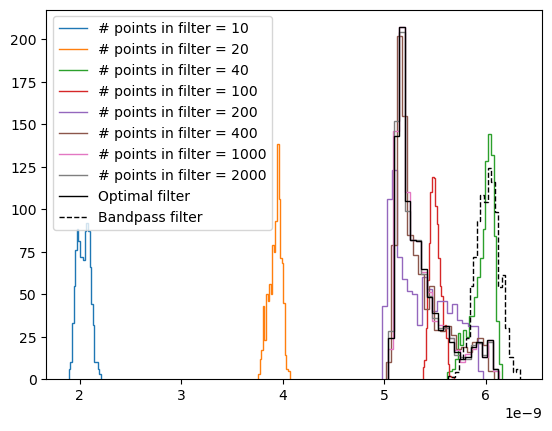

In [381]:
for n, corr_max in enumerate(corr_max_l):
    hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))

mdict = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5')
corr_max2 = mdict['Kicks']
amp_max2 = mdict['Band-pass filter']

hist2, bins2= au.histogram_and_fit(corr_max2, 20, 5, fit = False, plot = False)
hist3, bins3= au.histogram_and_fit(np.array(amp_max2)*6.3, 20, 5, fit = False, plot = False)


plt.stairs(hist2, bins2, label = 'Optimal filter', color = 'k')
plt.stairs(hist3, bins3, label = 'Bandpass filter', color = 'k', linestyle = '--')
plt.legend()

In [384]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.1]
bands = [55, 60, 65, 70, 75, 80, 85, 90, 95, 100]#[10, 15, 20, 25, 30, 35, 40, 45, 50]
#corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1


C:\Users\thoma\AppData\Local\Temp\ipykernel_17932\2579869729.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(bands[:], widths*300/means, 'o')


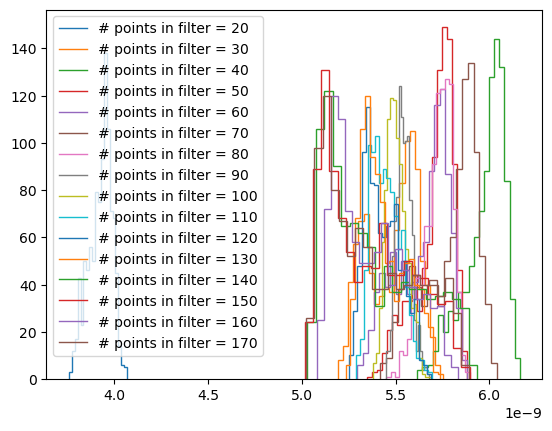

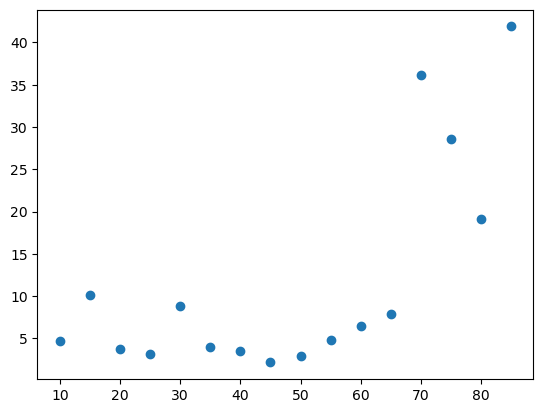

In [391]:
means = np.zeros(len(corr_max_l))
widths = np.zeros(len(corr_max_l))
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
for n, corr_max in enumerate(corr_max_l[:-3]):
    hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
    means[n] = abs(fit[1])
    widths[n] = abs(fit[2])
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
    #plt.plot(x_hist, fitted)

plt.legend()

plt.figure()
plt.plot(bands[:], widths*300/means, 'o')

In [ ]:
# So using like +- 40 - 50 points around the centre seems good for 0.1 modulation depth.
# Let's try a different modulation depth

In [393]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.02]
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
#corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            # corr_max_n = []
            # #corr_data_l_n = np.zeros((1000, numbins))
            # np.random.seed(3716)
            # for i in range(1000):
            #     data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
            #     x = data['x']
            #     cm = au.optimal_filter_noise(phi_t, x)
            #     corr_max_n.append(cm)
            # print(2)
            # cf = 55000
            # BW = 30000
            # amp_max = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find2(filename+'/Kicks/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max.append(max)
            
            # print(3)
            
            # amp_max_n = []
            # for i in range(1000):
            #     max = au.bandpass_peak_find_noise2(filename+'/Noise/' + str(i) +'.hdf5', cf, BW, 10**6, 3)
            #     amp_max_n.append(max)

            # print(4)
            
            # analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
            # au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [397]:
len(bands)

19

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


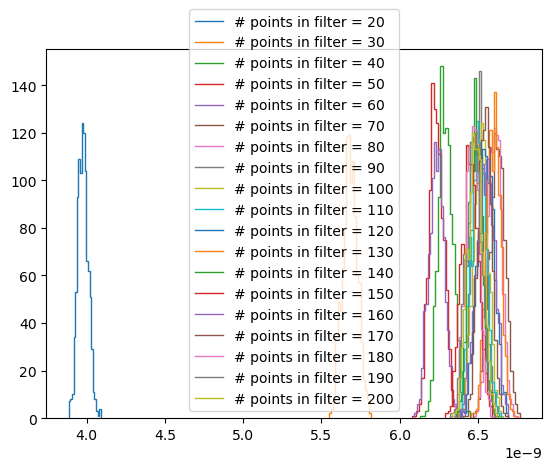

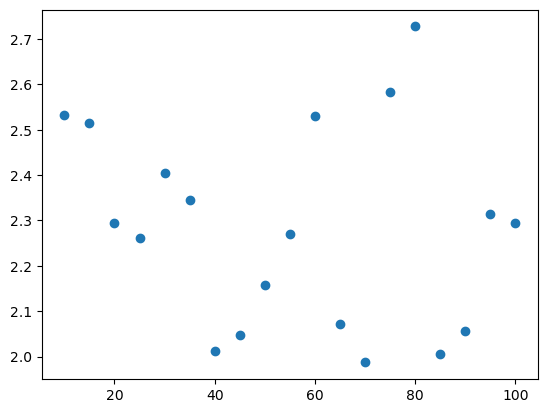

In [401]:
means = np.zeros(len(bands))
widths = np.zeros(len(bands))
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
for n, corr_max in enumerate(corr_max_l[19:]):
    print(n)
    hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
    means[n] = abs(fit[1])
    widths[n] = abs(fit[2])
    plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
    #plt.plot(x_hist, fitted)

plt.legend()

plt.figure()
plt.plot(bands[:], widths*300/means, 'o')

In [4]:
importlib.reload(au)

# Load in noise and response templates

filename1 ='D:/Simulation Data/240529/Frequency modulation/Short_template'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
corr_max_l = []
for band in bands:
    for yfb in yfb_l:
        for iter in iter_l:

            numbins = int(2*5*10**4*100*2*np.pi/yfb)

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)

            data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
            PSD_freq = data['frequency']
            PSD_noise = data['J']

            data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            avr_resp = data['x']

            phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

            corr_max = []
            #corr_arg = []
            #corr_data_l = np.zeros((1000, numbins))
            for i in range(1000):
                data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
                x = data['x']
                cm = au.optimal_filter_short(phi_t, x, band)
                corr_max.append(cm)
            print(1)
            corr_max_l.append(corr_max)
            
            analysis_dict = {'Kicks': corr_max}
            au.save_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter)  + '_' + str(band) +'.hdf5', analysis_dict)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


IndexError: index 19 is out of bounds for axis 0 with size 19

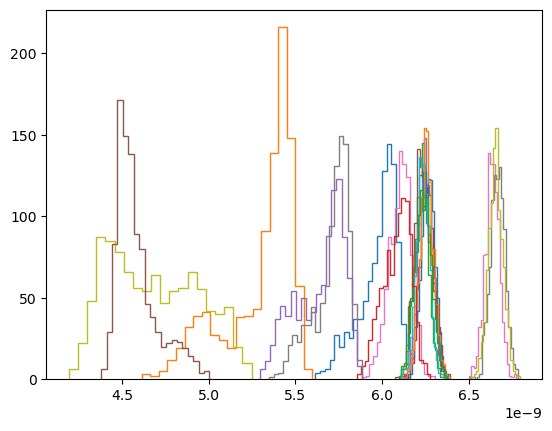

In [5]:
yfb_l = np.array([1000])*2*np.pi
bands = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
iter_l = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

filename1 ='D:/Simulation Data/240529/Frequency modulation/Short_template'

for yfb in yfb_l:
    for iter in iter_l:
        widths = np.zeros(len(bands))
        means = np.zeros(len(bands))
        plt.figure()
        for n, band in enumerate(bands):
            data = au.load_data_hdf5(filename1 + 'analysis' + str(int(yfb/2/np.pi)) + '_' + str(iter)  + '_' + str(band) +'.hdf5')
            corr_max = data['Kicks']
            try:
                hist1, bins1, fit, x_hist, fitted = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
                means[n] = abs(fit[1])
                widths[n] = abs(fit[2])
                plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
                plt.plot(x_hist, fitted)
            except RuntimeError:
                hist1, bins1 = au.histogram_and_fit(corr_max, 20, 5, fit = False, plot = False)
                means[n] = 'Nan'
                widths[n] = 'Nan'
                plt.stairs(hist1, bins1, label = '# points in filter = ' + str(2*bands[n]))
        plt.legend()
        plt.figure()
        plt.plot(bands[:], widths*300/means, 'o', label = str(iter*55000/1000))
        plt.ylabel('Reconstructed width (arb)')
        plt.xlabel('Number of points in reconstruction')
        plt.legend()

# Trying to measure instantaneous frequency and correct for this

There are definitely issues with the way I generate the data. By modulating the time I effectively modulate damping and force noise as well as frequency

I also think this is only going to work for drifts that are on timescales much longer (x10?) than the damping :/

In [238]:
filename = 'D:/Simulation Data/240529/Frequency modulation/yfb1000/0.2/'
data = au.load_data_hdf5(filename+'/Kicks/510.hdf5')

In [410]:
# Okay, let's write this into a loop and do this. Start with just creating a noise template.

#filename1 ='D:/Simulation Data/240529/Frequency modulation/'

yfb_l = np.array([1000])*2*np.pi
iter_l = [0.1]
for yfb in yfb_l:
    numbins = int(2*5*10**4*100*2*np.pi/yfb)
    for iter in iter_l:
        PSD_noise = np.zeros(int(numbins/2))
        for file in range(100):

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)
            data = au.load_data_hdf5(filename+'/Noise/'+str(file)+'.hdf5')
            x = data['x']
            time, R2, R2_filt, theta_filt = au.lockin(x, fs=10**6, demod_freq=55000, BW_pre = 10000, BW = 50000, BW2 = 250, mode = 'R')
            x_mod = su.frequency_modulation(x[1:], (theta_filt/2/np.pi/55000)+time[1:], time[1:])
            PSD = scisig.welch(x_mod, fs = 10**6, nperseg = numbins-1)
            PSD_noise += PSD[1]

        # Save J
        PSD_noise /= 100
        PSD_freq = PSD[0]
        mdict = {'J':PSD_noise, 'frequency':PSD_freq}
        sio.savemat(filename+'/Noise/PSD_corrected.mat', mdict)

            # data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
            # avr_resp = data['x']

            # data = au.load_data_hdf5(filename+'/Kicks/0.hdf5')

            # phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)


In [415]:
filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))
data = sio.loadmat(filename+'/Noise/'+str(file)+'.mat')
x2 = data['x'][0]

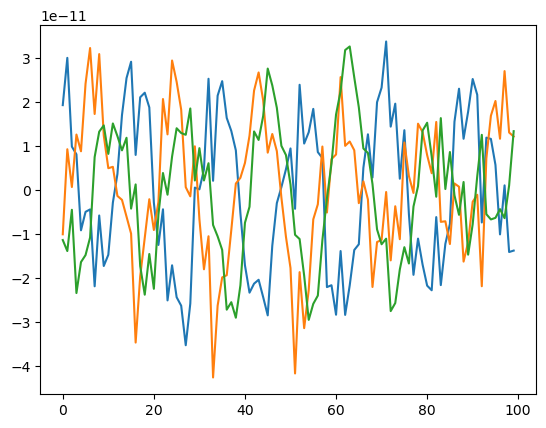

In [421]:
plt.plot(x[5000:5100])
plt.plot(x2[5000:5100])
plt.plot(x_mod[5000:5100])

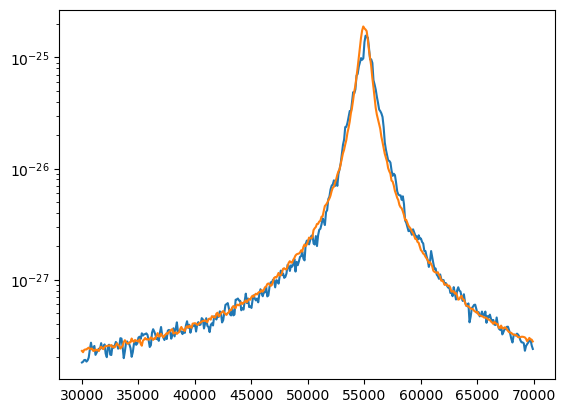

In [411]:
plt.plot(PSD_freq[300:700], PSD_noise[300:700])
plt.plot(PSD_freq2[300:700], PSD_noise2[300:700])
plt.yscale('log')

In [342]:
yfb_l = np.array([1000])*2*np.pi
iter_l = [0.0]
for yfb in yfb_l:
    numbins = int(2*5*10**4*100*2*np.pi/yfb)
    for iter in iter_l:
        avr_resp= np.zeros(int(numbins)-1)
        for file in range(1000):

            filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)
            data = au.load_data_hdf5(filename+'/Kicks/'+str(file)+'.hdf5')
            x = data['x']
            time, R2, R2_filt, theta_filt = au.lockin(x, fs=10**6, demod_freq=55000, BW_pre = 10000, BW = 50000, BW2 = 1000, mode = 'R')
            x_mod = su.frequency_modulation(x[1:], (theta_filt/2/np.pi/55000)+time[1:], time[1:])
            arg_kick = np.argmin(abs((theta_filt/2/np.pi/55000)+time[1:] - 0.005))
            if arg_kick < 5000:
                x_mod = np.concatenate((np.zeros(5000 - arg_kick), x_mod[:len(x_mod) - (5000 - arg_kick)]))
            elif arg_kick > 5000:
                x_mod = np.concatenate((x_mod[arg_kick-5000:], np.zeros(arg_kick-5000)))
            avr_resp += x_mod

        # Save J
        avr_resp /= 1000
        mdict = {'x':avr_resp}
        sio.savemat(filename+'/Kicks/avr_resp_corrected.mat', mdict)

In [344]:
yfb_l = np.array([1000])*2*np.pi
for yfb in yfb_l:
    filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))
    data = sio.loadmat(filename+'/Noise/PSD.mat')
    PSD_freq2 = data['frequency'][0]
    PSD_noise2 = data['J'][0]

    filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)
    data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
    PSD_freq3 = data['frequency']
    PSD_noise3 = data['J']
    

In [345]:
yfb_l = np.array([1000])*2*np.pi
for yfb in yfb_l:
    filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))
    data = sio.loadmat(filename+'/Kicks/avr_resp.mat')
    avr_resp2 = data['x'][0]

    filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi)) + '/' + str(iter)
    data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
    avr_resp3 = data['x']

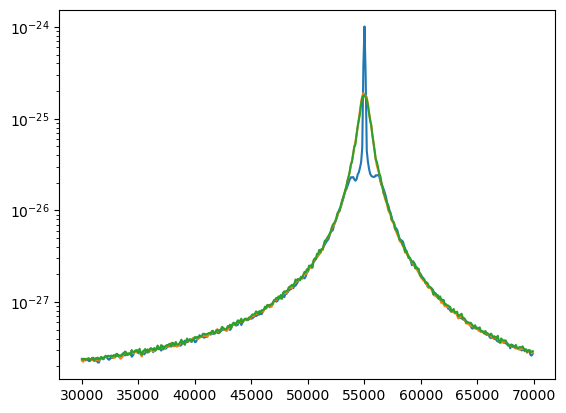

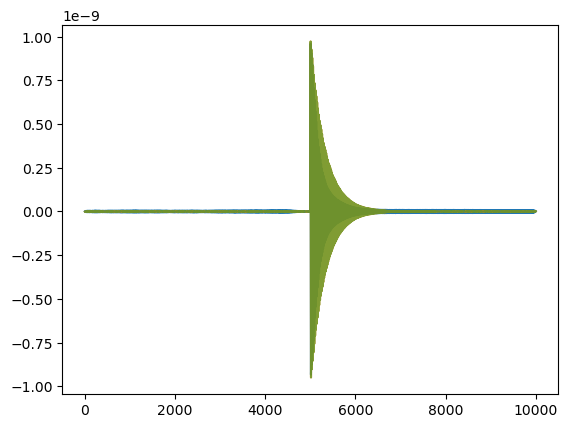

In [346]:
freq2 = np.linspace(0, 500000, 500000)
exp = au.Linewidth2(freq2, 6*10**-13, 55000, 1000, 10**(-28))

lb = 300
ub = 700
plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
plt.plot(PSD_freq2[lb:ub], PSD_noise2[lb:ub])
plt.plot(PSD_freq3[lb:ub], PSD_noise3[lb:ub])
#plt.plot(freq2[lb*100:ub*100], exp[lb*100:ub*100])
plt.yscale('log')
plt.figure()
plt.plot(avr_resp)
plt.plot(avr_resp2, alpha = 0.8)
plt.plot(avr_resp3, alpha = 0.6)

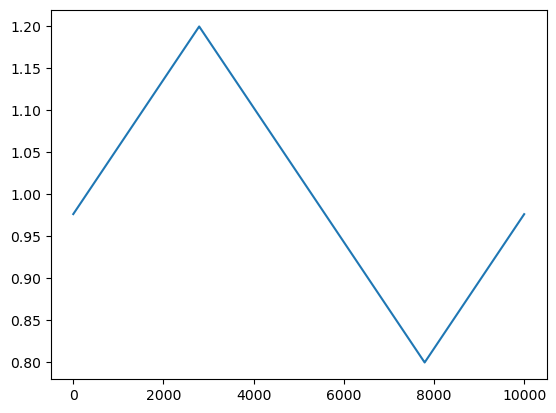

In [239]:
plt.plot(data['fm'])

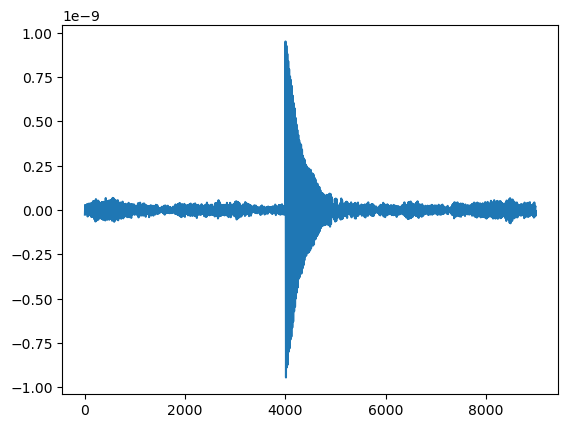

In [240]:
plt.plot(data['x'][1000:])

In [241]:
PSD = scisig.welch(data['x'], fs = 10**6, nperseg = 10**3)

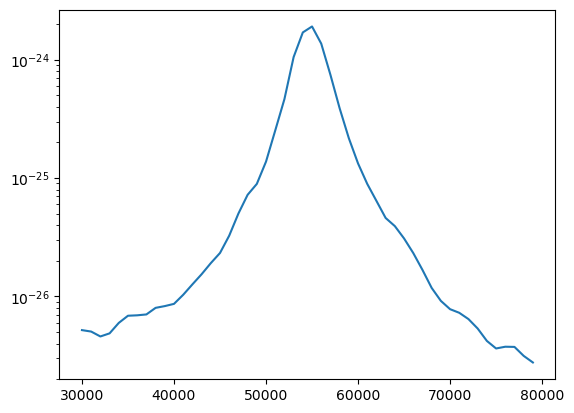

In [242]:
lb = 30
ub = 80
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')

In [249]:
importlib.reload(au)

time, R2, R2_filt, theta_filt = au.lockin(data['x'], fs=10**6, demod_freq=55000, BW_pre = 10000, BW = 50000, BW2 = 1000, mode = 'R')

C:\Users\thoma\AppData\Local\Temp\ipykernel_20564\206519828.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(time, np.sqrt(R2_filt))


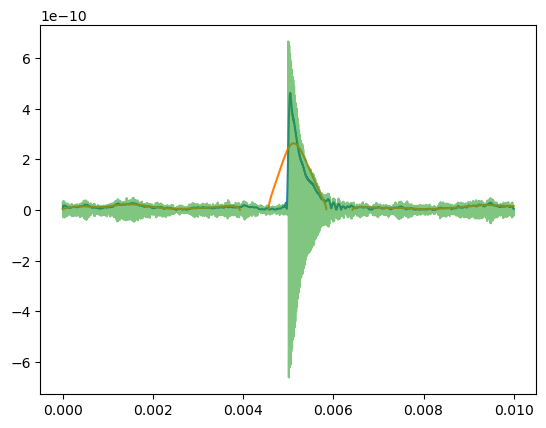

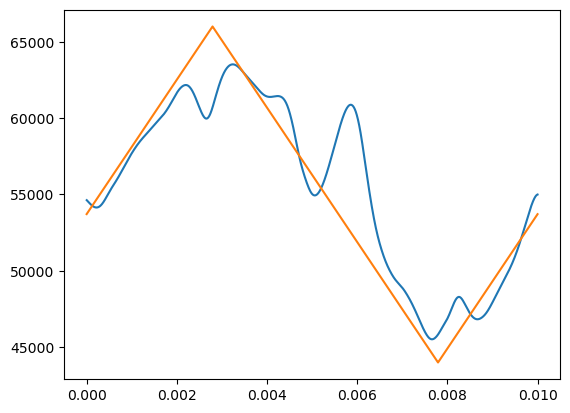

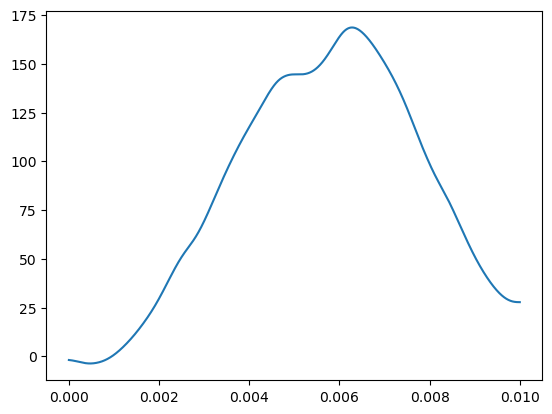

In [250]:
plt.plot(time, np.sqrt(R2))
plt.plot(time, np.sqrt(R2_filt))
plt.plot(time, np.array(data['x'])*0.7, alpha = 0.6)
plt.figure()
plt.plot(time[2:], 55000+(theta_filt[1:]-theta_filt[:-1])*10**6/2/np.pi)
plt.plot(time, np.array(data['fm'])*55000)
plt.figure()
plt.plot(time[1:], theta_filt)

In [251]:
x_mod = su.frequency_modulation(data['x'][1:], (theta_filt/2/np.pi/55000)+time[1:], time[1:])

In [252]:
PSD_mod = scisig.welch(x_mod, fs = 10**6, nperseg = 10**3)

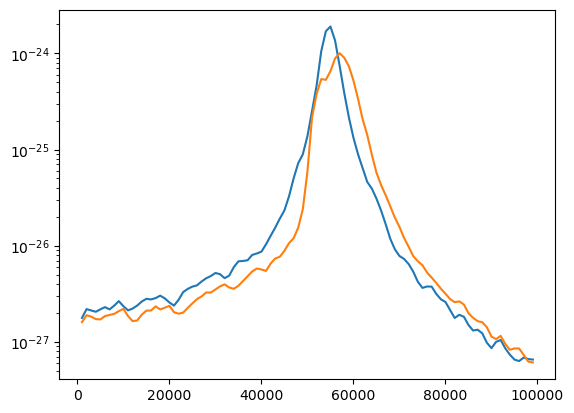

In [253]:
lb = 1
ub = 100
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.plot(PSD_mod[0][lb:ub], PSD_mod[1][lb:ub])
plt.yscale('log')

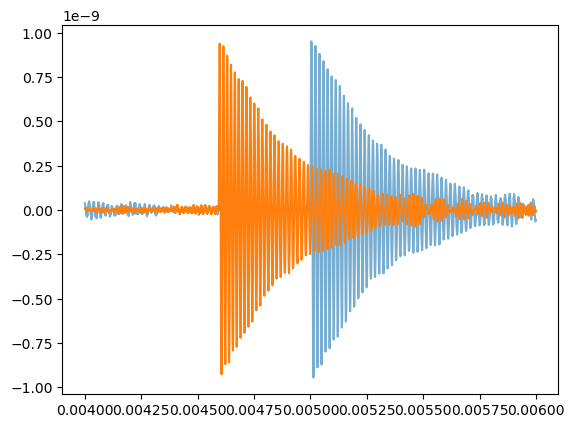

In [254]:
lb = 5000-1000
ub = 5000+1000
plt.plot(time[lb:ub], np.array(data['x'])[lb:ub], alpha = 0.6)
plt.plot(time[lb:ub], x_mod[lb:ub])

# Try getting R to get rid of frequency drifts then multiply by sin wave?